# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
numpy v1.21.5
chromatic v0.3.14
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

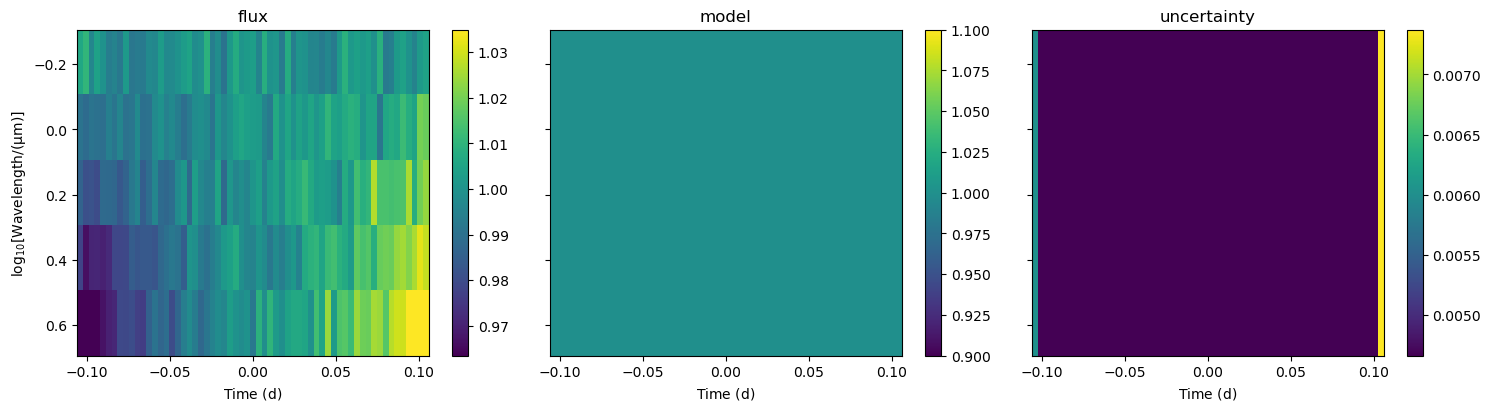

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

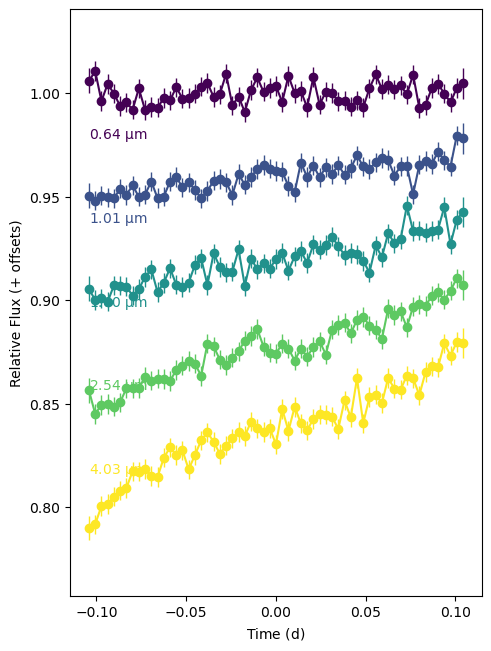

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.02,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.03,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.04,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>}

In [6]:
# setup model the same way as for the transit model!:
p.attach_data(rb)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
# p.choose_optimization_method("separate")

p.setup_lightcurves(store_models=True)

p.setup_likelihood()

In [7]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0', shape=5) for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1', shape=5) for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2', shape=5) for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3', shape=5) for each wavelength 🧮>}

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [8]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [9]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6756279.470641921 -> 1177.2282275814596
/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 12 seconds.


Now we can look at our results:

In [10]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                             mean        sd   hdi_16%   hdi_84%  mcse_mean  \
polynomial_p_0[0]        0.999546  0.000910  0.998637  1.000446   0.000005   
polynomial_p_0[1]        1.000131  0.000899  0.999233  1.001007   0.000005   
polynomial_p_0[2]        0.999732  0.000912  0.998807  1.000615   0.000005   
polynomial_p_0[3]        0.998813  0.000909  0.997944  0.999754   0.000005   
polynomial_p_0[4]        1.000693  0.000906  0.999713  1.001526   0.000005   
...                           ...       ...       ...       ...        ...   
polynomial_model[4, 56]  1.031972  0.001427  1.030576  1.033415   0.000010   
polynomial_model[4, 57]  1.034394  0.001573  1.032819  1.035951   0.000011   
polynomial_model[4, 58]  1.036956  0.001742  1.035335  1.038795   0.000013   
polynomial_model[4, 59]  1.039664  0.001933  1.037726  1.041570   0.000015   
polynomial_model[4, 60]  1.042522  0.002147  1.040376  1.044649   0.000017   

                          mcse_sd      ess_bulk      ess_tail  

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [11]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,0.999546,0.998637,1.000446,0.018932,0.004341,0.041006,0.045825,-0.150089,0.221547,-1.404003,-4.962644,-0.473459,0.639572482934883 micron
w1,1.000131,0.999233,1.001007,0.077758,0.053878,0.101607,-0.033574,-0.211865,0.155867,2.595323,-1.022016,5.728517,1.013209338074884 micron
w2,0.999732,0.998807,1.000615,0.121199,0.096504,0.144934,0.104932,-0.076894,0.301517,6.421818,3.040617,9.982683,1.604998553797903 micron
w3,0.998813,0.997944,0.999754,0.148616,0.124796,0.174154,-0.029291,-0.217188,0.144603,15.194762,11.741321,18.709444,2.542436455025025 micron
w4,1.000693,0.999713,1.001526,0.188432,0.165287,0.202577,-0.169004,-0.350633,0.019255,21.264014,20.303773,24.993577,4.027407446906737 micron


In [12]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

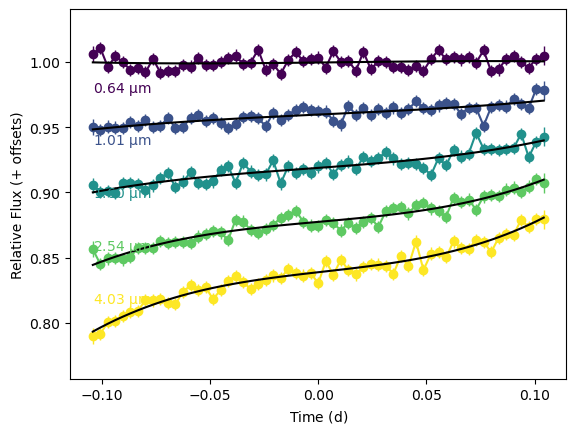

In [13]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


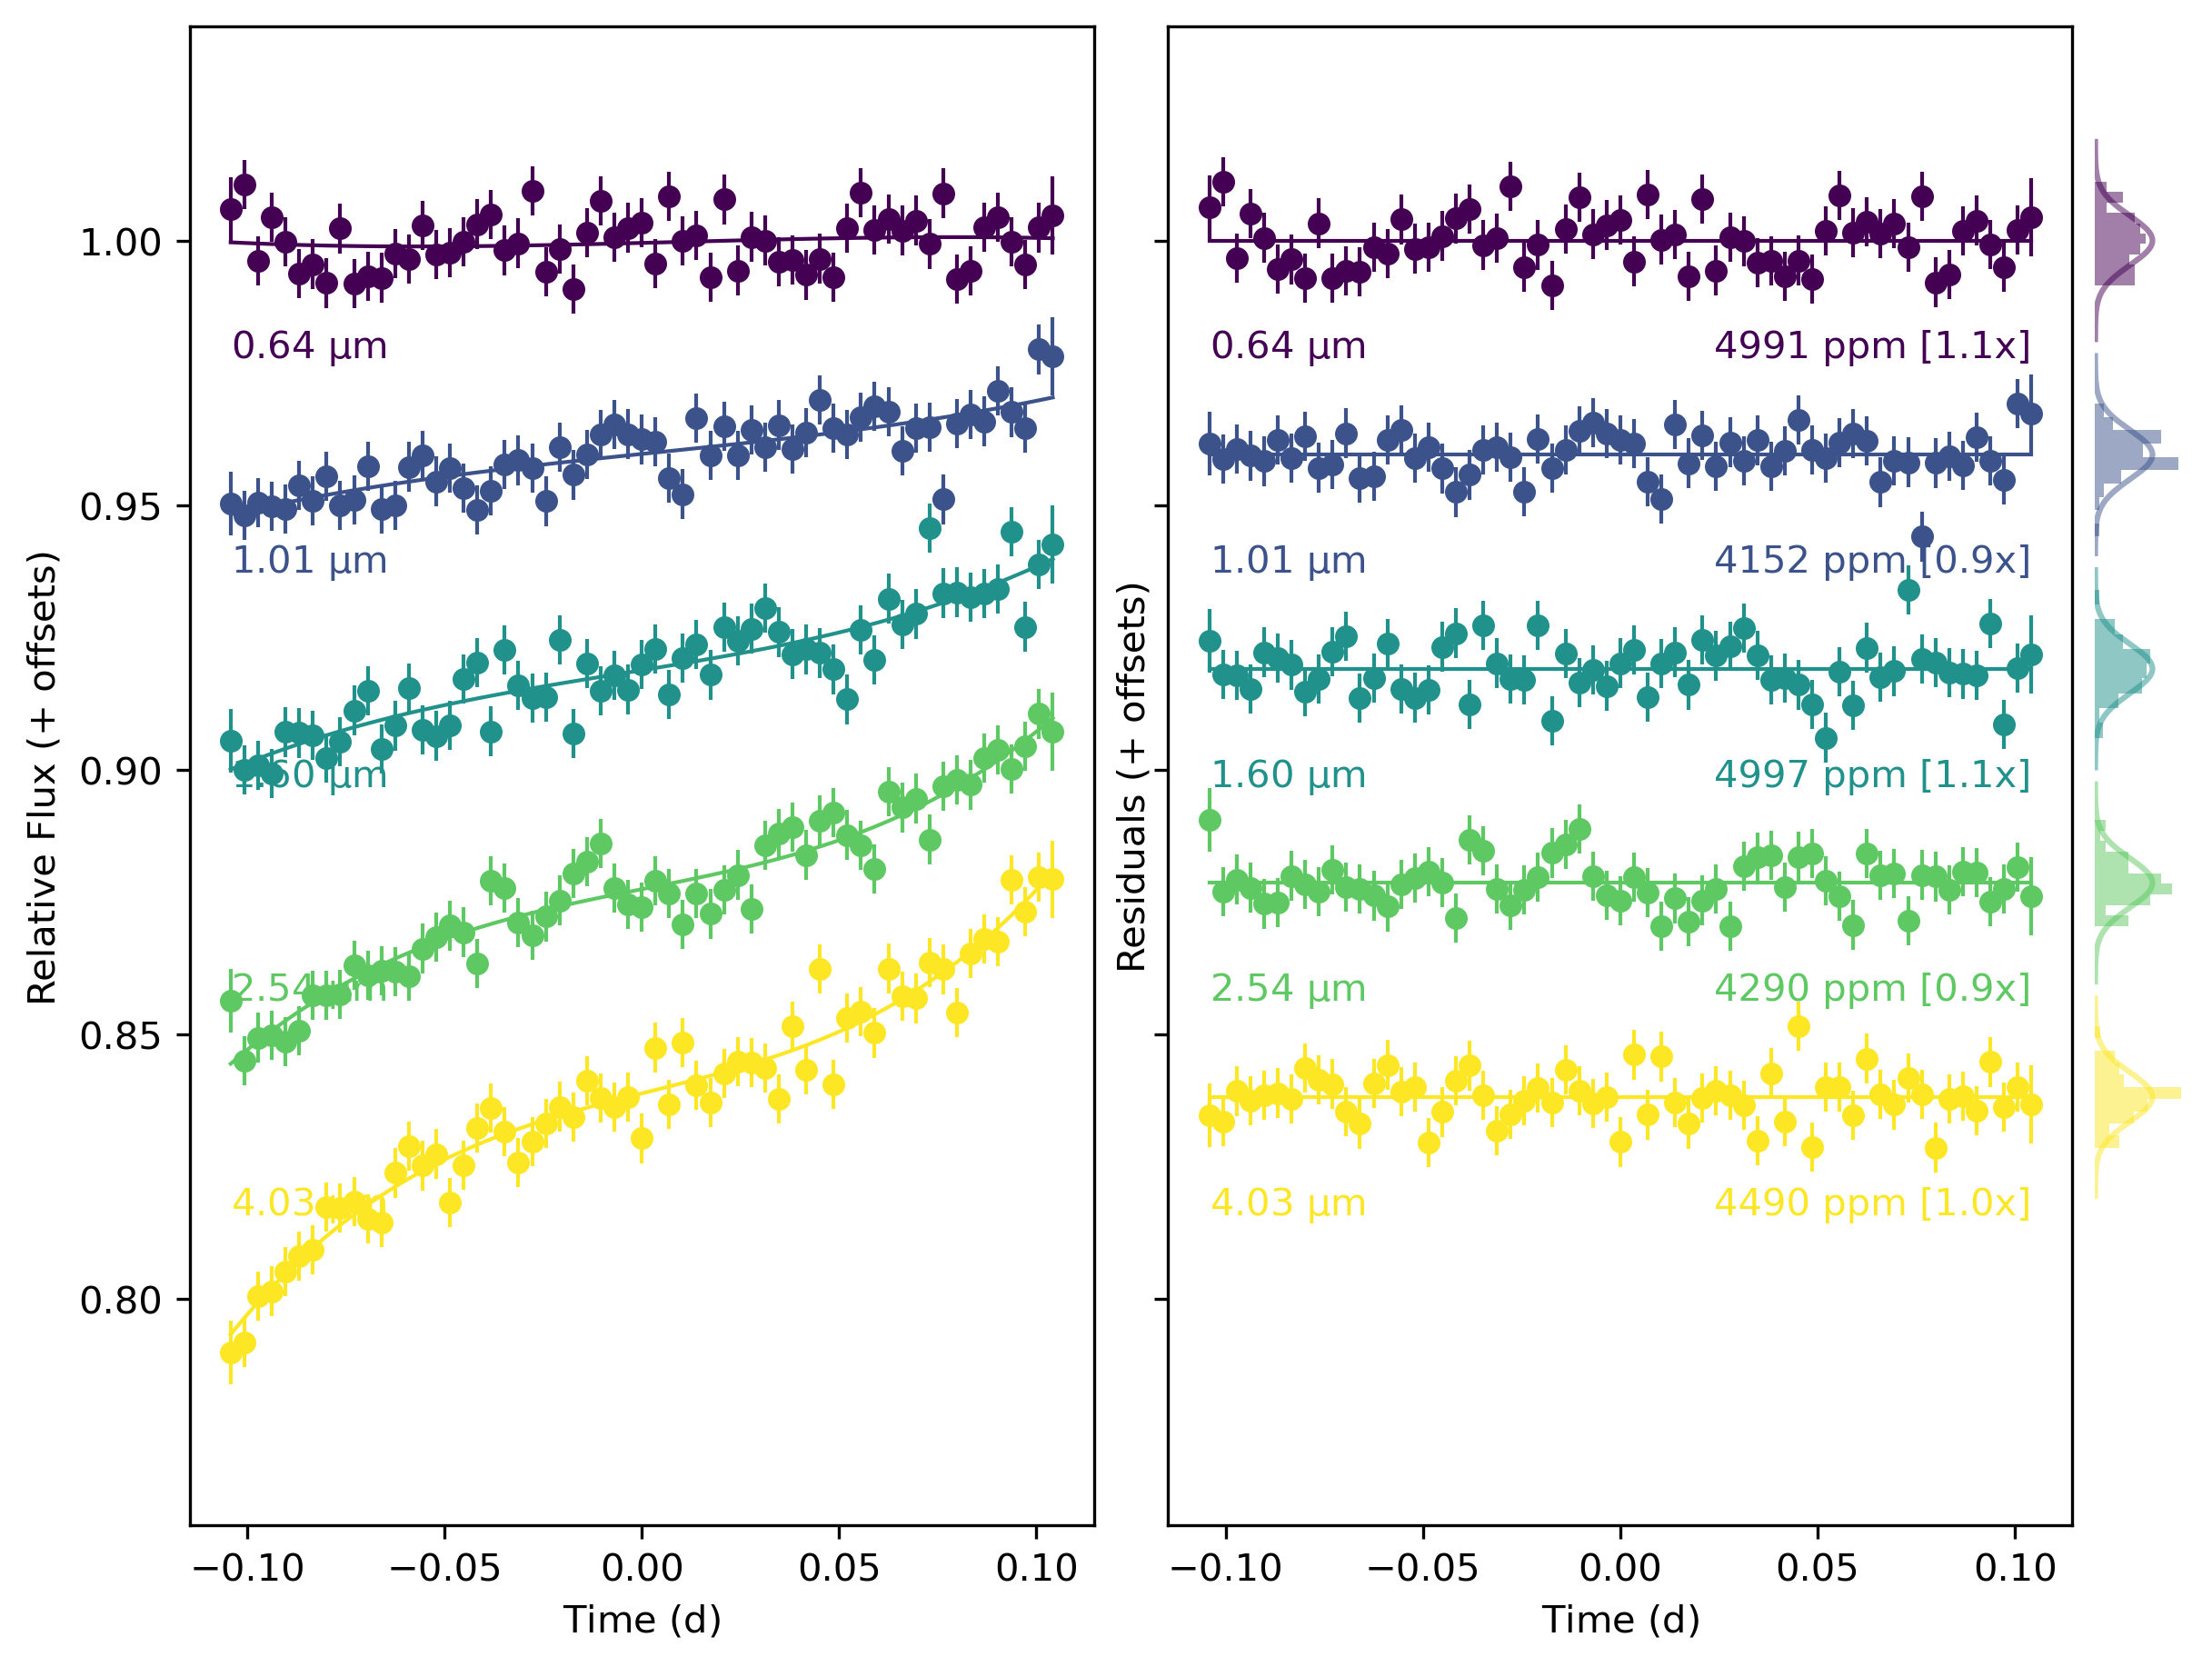

In [14]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



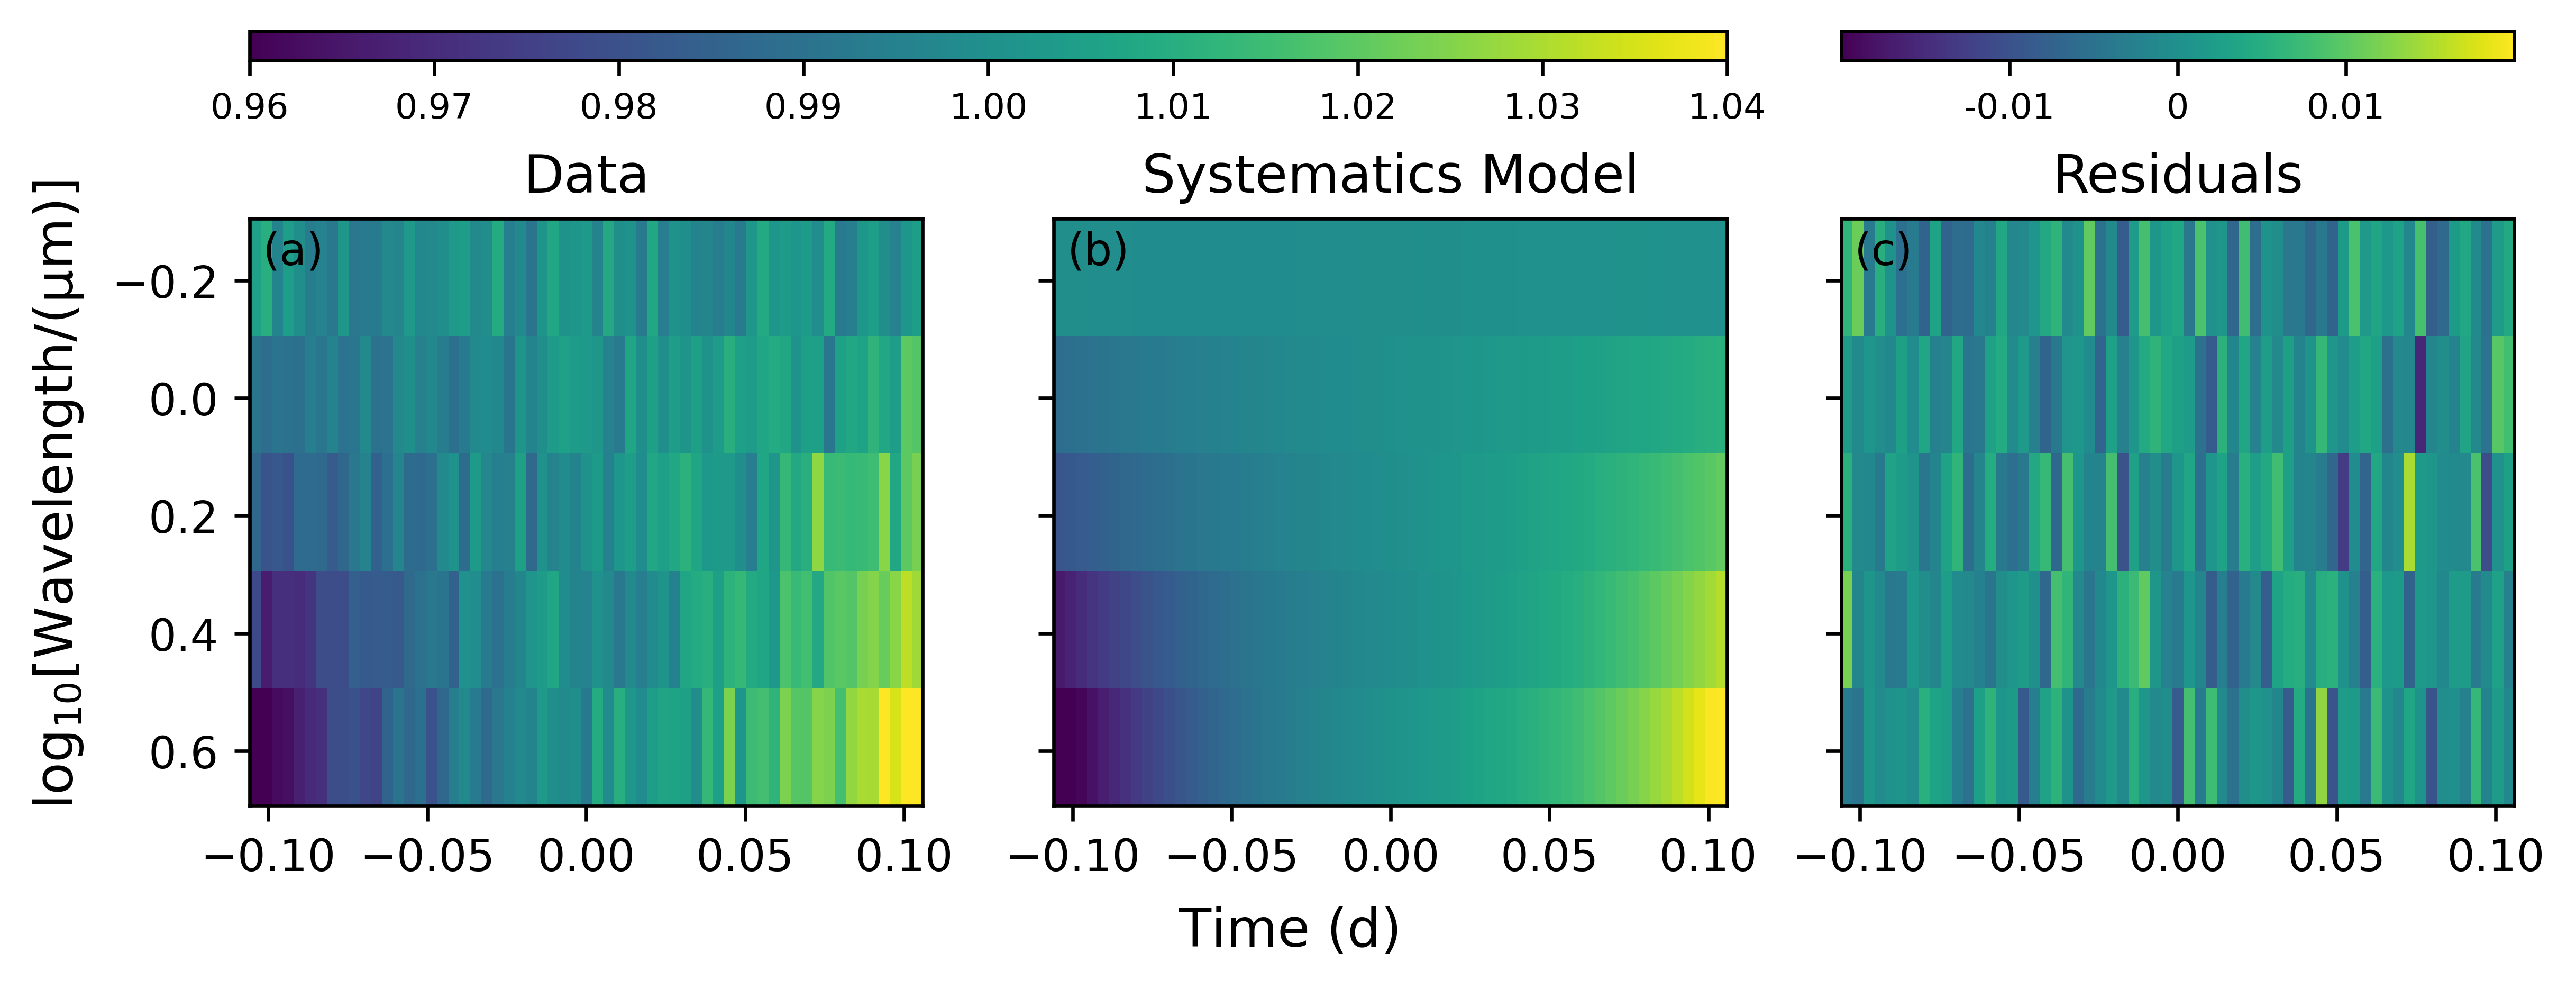

In [15]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [16]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,0.999546,0.00091,0.018932,0.018885,0.045825,0.186815,-1.404003,2.468236,0.639572482934883 micron
w1,1.000131,0.000899,0.077758,0.023734,-0.033574,0.186556,2.595323,3.322111,1.013209338074884 micron
w2,0.999732,0.000912,0.121199,0.024452,0.104932,0.188231,6.421818,3.452233,1.604998553797903 micron
w3,0.998813,0.000909,0.148616,0.024725,-0.029291,0.184894,15.194762,3.460239,2.542436455025025 micron
w4,1.000693,0.000906,0.188432,0.019008,-0.169004,0.185967,21.264014,2.516157,4.027407446906737 micron


In [17]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 0.9995462 +/- 0.0009098
wavelength 0, p_1:	 0.0, 	 0.0189324 +/- 0.0188848
wavelength 0, p_2:	 0.0, 	 0.0458254 +/- 0.1868152
wavelength 0, p_3:	 0.0, 	 -1.4040031 +/- 2.4682364
wavelength 1, p_0:	 1.0, 	 1.000131 +/- 0.0008986
wavelength 1, p_1:	 0.05, 	 0.0777577 +/- 0.023734
wavelength 1, p_2:	 0.0, 	 -0.0335741 +/- 0.1865565
wavelength 1, p_3:	 5.0, 	 2.5953226 +/- 3.3221109
wavelength 2, p_0:	 1.0, 	 0.9997322 +/- 0.0009118
wavelength 2, p_1:	 0.1, 	 0.1211989 +/- 0.024452
wavelength 2, p_2:	 0.0, 	 0.1049324 +/- 0.1882311
wavelength 2, p_3:	 10.0, 	 6.4218177 +/- 3.4522332
wavelength 3, p_0:	 1.0, 	 0.9988132 +/- 0.0009093
wavelength 3, p_1:	 0.15, 	 0.1486159 +/- 0.024725
wavelength 3, p_2:	 0.0, 	 -0.029291 +/- 0.1848944
wavelength 3, p_3:	 15.0, 	 15.1947618 +/- 3.4602393
wavelength 4, p_0:	 1.0, 	 1.0006932 +/- 0.0009062
wavelength 4, p_1:	 0.2, 	 0.1884323 +/- 0.019008
wavelength 4, p_2:	 0.0, 	 -0.1690036 +/- 0.1859672
wavelength 

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

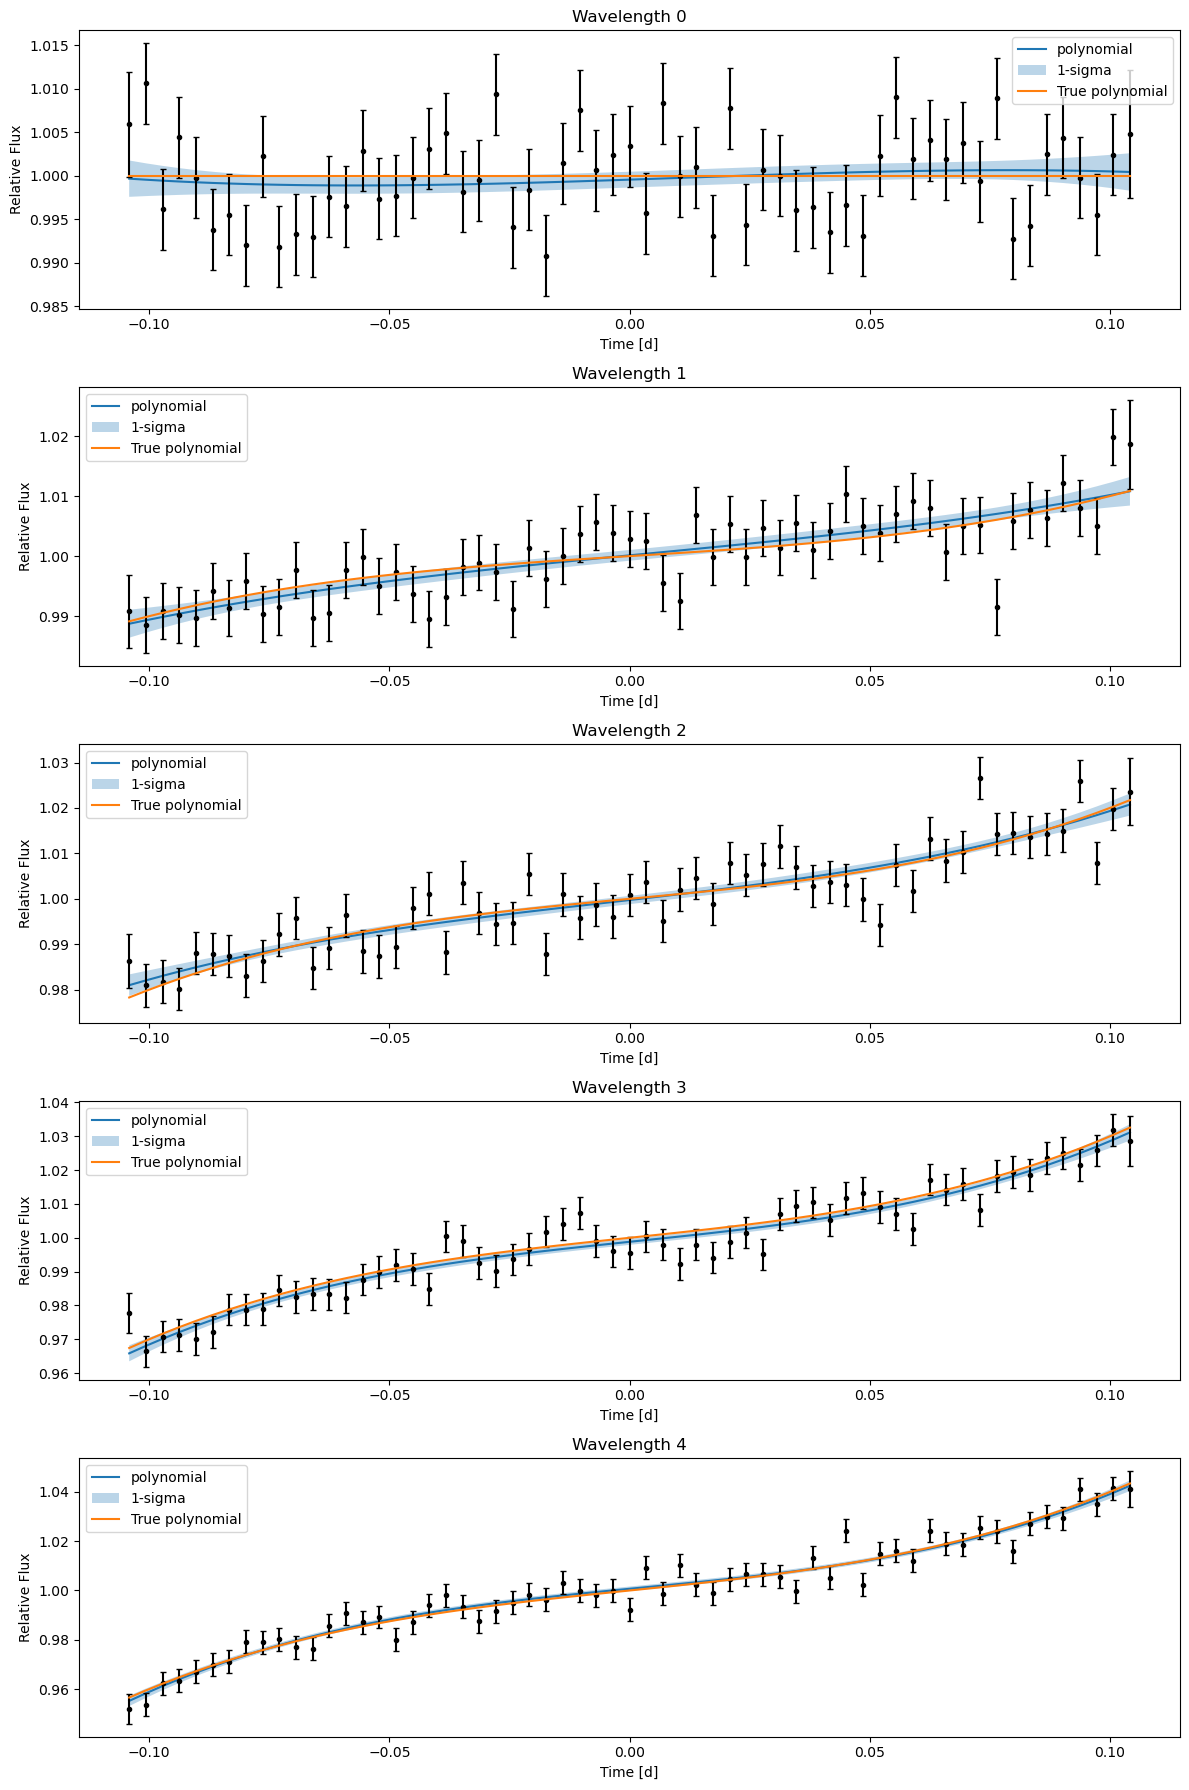

In [18]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        if p.optimization == "separate":
            onesigma[f"w{w}"].append(p.summary[w]["sd"][f"{p.name}_model[0, {t}]"])
        else:
            onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, poly[i] + 1, label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).